# Reconocimiento de comandos de voz

In [35]:
try:
    import torchinfo
except:
    ! pip install torchinfo
try:
    import torchaudio
except:
    ! pip install torchaudio

In [36]:
import random
from itertools import islice as take
import librosa
import librosa.display
import IPython as ip
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import torchvision.models as tvm
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from torchinfo import summary
from tqdm.auto import trange
import collections
from os.path import join
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

Otras importaciones

In [37]:
!pip install einops

In [38]:
from torch.optim import Adam
from einops import rearrange, repeat

In [39]:
#Creamos carpeta en colab para los datos (no ejecutar si ya existe la carpeta):
! mkdir datos

mkdir: cannot create directory ‘datos’: File exists


In [40]:
# directorio de datos
DATA_DIR = 'datos'
ds = SPEECHCOMMANDS(DATA_DIR, download=True)

## El conjunto de datos

In [41]:
# tamaño del lote
BATCH_SIZE = 32

# parámetros de audio
SECS = 1
SAMPLE_RATE = 16000

# parámetros FFT
N_FFT = 400
HOP_LENGTH = N_FFT // 2

# SpeechCommands classes
CLASSES = (
    'backward', 'bed', 'bird', 'cat', 'dog',
    'down', 'eight', 'five', 'follow', 'forward',
    'four', 'go', 'happy', 'house', 'learn',
    'left', 'marvin', 'nine', 'no', 'off',
    'on', 'one', 'right', 'seven', 'sheila',
    'six', 'stop', 'three', 'tree', 'two',
    'up', 'visual', 'wow', 'yes', 'zero'
)

NUM_CLASSES = len(CLASSES)
CLASS_IDX = {c: i for i, c in enumerate(CLASSES)}
print(CLASS_IDX)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed(150)

{'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34}


Se define la función para transformación a espectrograma Mel.

In [42]:
melspect = T.MelSpectrogram(n_fft=N_FFT, hop_length=HOP_LENGTH)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [43]:
def identity(x):
    return x


def label2index(label):
    return CLASS_IDX[label]


class SPEECHCOMMANDS2(SPEECHCOMMANDS):

    def __init__(self, root, download=False, subset=None,
                 waveform_tsfm=identity, label_tsfm=identity):
        super().__init__(root=root, download=download, subset=subset)
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm

    def __getitem__(self, i):
        waveform, sample_rate, label, *_ = super().__getitem__(i)
        x = melspect(self.waveform_tsfm(waveform)) # se aplica la transformación a espectrograma Mel
        y = self.label_tsfm(label)
        return x, y, label, sample_rate

In [44]:
class WaveformPadTruncate(nn.Module):

    def __init__(self, secs=SECS, sample_rate=SAMPLE_RATE):
        super().__init__()
        self.samples = secs * sample_rate

    def forward(self, waveform):
        samples = waveform.shape[1]

        if samples < self.samples:
            difference = self.samples - samples
            padding = torch.zeros(1, difference)
            waveform = torch.cat([waveform, padding], 1)

        elif samples > self.samples:
            start = random.randint(0, waveform.shape[1] - self.samples)
            # Devuelve un nuevo tensor que es una versión reducida del tensor de entrada.
            waveform = waveform.narrow(1, start, self.samples) # (dimension, start, length)

        return waveform

## Dataset y Dataloader

In [45]:
# creamos un Dataset
ds_ent = SPEECHCOMMANDS2(
    # directorio de datos
    root=DATA_DIR,
    # transformación de la forma de onda
    waveform_tsfm = WaveformPadTruncate(),
    # transformación de etiqueta
    label_tsfm=label2index,
    subset = "training"
)

ds_val = SPEECHCOMMANDS2(
    # directorio de datos
    root=DATA_DIR,
    # transformación de la forma de onda
    waveform_tsfm = WaveformPadTruncate(),
    # transformación de etiqueta
    label_tsfm=label2index,
    subset = "validation"
)

ds_pru = SPEECHCOMMANDS2(
    # directorio de datos
    root=DATA_DIR,
    # transformación de la forma de onda
    waveform_tsfm = WaveformPadTruncate(),
    # transformación de etiqueta
    label_tsfm=label2index,
    subset = "testing"
)

print("Tamaño entrenamiento:",len(ds_ent))
print("Tamaño validación:", len(ds_val))
print("Tamaño prueba:", len(ds_pru))

Tamaño entrenamiento: 84843
Tamaño validación: 9981
Tamaño prueba: 11005


Se crean los cargadores de datos.

In [46]:
# creamos los DataLoader
dl_ent = DataLoader(ds_ent, batch_size=BATCH_SIZE, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True)
dl_pru = DataLoader(ds_pru, batch_size=1, shuffle=True)

Se observa la forma de un lote (de 32).

In [47]:
x_sample, y_sample, labels_sample, sr_sample = next(iter(dl_ent))
print(f'x shape={x_sample.shape} dtype={x_sample.dtype}')
print(f'y shape={y_sample.shape} dtype={y_sample.dtype}')

x shape=torch.Size([32, 1, 128, 81]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


Ahora se observa el aplanamiento de un lote de X.

In [48]:
x_sample_plano = torch.flatten(x_sample, start_dim = 2)
print(f'x shape={x_sample_plano.shape}')

x shape=torch.Size([32, 1, 10368])


## Entrenamiento y redes

In [49]:
# Constantes para el entrenamiento
N_EPOCAS = 20 # cambiar
LOGDIR = './logs/'
DC = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [50]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
    estado_modelo = {'epoch': epoca,
                     'model_state_dict': modelo.state_dict(),
                     'optimizer_state_dict': opt.state_dict()}
    torch.save(estado_modelo, ckptpath)

In [51]:
def registra_info_tboard(writer, epoca, hist):
    for (m,v) in hist.items():
        writer.add_scalar(m, v[epoca], epoca)

In [52]:
def exactitud(y_hat, y):
    cmp = y_hat.argmax(dim=-1) == y
    aciertos = torch.count_nonzero(cmp)
    return aciertos / cmp.shape[0]

In [53]:
def paso_ent(modelo, fp, metrica, opt, X, y):
    opt.zero_grad() # se ponen los gradientes asociados a los parámetros a actualizar en cero
    y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
    perdida = fp(y_hat, y) # se calcula la pérdida
    perdida.backward() # se obtienen los gradientes
    opt.step() # se actualizan todos los parámetros del modelo

    with torch.no_grad():
        perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
        metricas_paso = metrica(y_hat, y)

    return perdida_paso, metricas_paso

In [54]:
import copy

def entrena(modelo, fp, metrica, opt, entdl, valdl, disp, ckptpath, n_epocas = 10, tbdir = 'runs/', aplanar=False):
    n_lotes_ent = len(entdl)
    n_lotes_val = len(valdl)

    hist = {'perdida_ent':np.zeros(n_epocas),
            'perdida_val': np.zeros(n_epocas),
            metrica.__name__ + '_ent': np.zeros(n_epocas),
            metrica.__name__ + '_val': np.zeros(n_epocas)}

    tbwriter = SummaryWriter(tbdir)
    perdida_min = torch.inf
    mejor_modelo = copy.deepcopy(modelo)
    for e in range(n_epocas):
        # bucle de entrenamiento
        modelo.train()
        for p, (Xlote,ylote,_,_) in enumerate(entdl):
            if(aplanar):
                Xlote = torch.flatten(Xlote, start_dim = 2)
            Xlote = pad(Xlote) # línea agregada
            Xlote = Xlote.to(disp)
            ylote = ylote.type(torch.LongTensor) # agregada
            ylote = ylote.to(disp)
            perdida_paso, metrica_paso = paso_ent(modelo, fp, metrica, opt, Xlote, ylote)
            hist['perdida_ent'][e] += perdida_paso
            hist[metrica.__name__ + '_ent'][e] += metrica_paso

        # bucle de validación
        modelo.eval()
        with torch.no_grad():
            for Xlote,ylote,_,_ in valdl:
                if(aplanar):
                    Xlote = torch.flatten(Xlote, start_dim = 2)
                Xlote = pad(Xlote) # línea agregada
                Xlote = Xlote.to(disp)
                ylote = ylote.type(torch.LongTensor) # agregada
                ylote = ylote.to(disp)
                y_hat = modelo(Xlote)
                hist['perdida_val'][e] += fp(y_hat, ylote)
                hist[metrica.__name__ + '_val'][e] += metrica(y_hat, ylote)

        hist['perdida_ent'][e] /=  n_lotes_ent
        hist[metrica.__name__ + '_ent'][e] /= n_lotes_ent
        hist['perdida_val'][e] /=  n_lotes_val
        hist[metrica.__name__ + '_val'][e] /= n_lotes_val
        # guardamos checkpoint y copiamos pesos y sesgos del modelo actual si disminuye la metrica a monitorear
        if hist['perdida_val'][e] < perdida_min:
            mejor_modelo.load_state_dict(modelo.state_dict())
            guarda_ckpt(ckptpath, modelo, e, opt)

        registra_info_tboard(tbwriter, e, hist)
        print(f'\nÉpoca {e}: Perdida(E) = {hist["perdida_ent"][e]:.3f}, {metrica.__name__}(E) = {hist[metrica.__name__ + "_ent"][e]:.3f}, Perdida(V) = {hist["perdida_val"][e]:.3f}, {metrica.__name__}(V) = {hist[metrica.__name__ + "_val"][e]:.3f}')
    return modelo, mejor_modelo, hist

## El modelo

In [55]:
class ProductoPuntoEscalado(nn.Module):
  def __init__(self,
               masc = False):
    super(ProductoPuntoEscalado, self).__init__()
    self.masc = masc

  def forward(self, Q, K, V):
    # Obtenemos dimensiones
    m, n_cabezas, l, d_k = K.shape
    d_v = V.shape[-1]

    # Cambiamos la forma: [m, n_cabezas, l, d_k] -> [m * n_cabezas, l, d_k]
    Q = Q.reshape(m * n_cabezas, l, d_k)
    K = K.reshape(m * n_cabezas, l, d_k)
    V = V.reshape(m * n_cabezas, l, d_v)

    # Q y K tienen forma [m * n_cabezas, l, d_k],
    # por lo que se transponen las dos últimas dimensiones de K
    # QK: [m * n_cabezas, l, l]
    QK = torch.bmm(Q, K.transpose(1, 2))

    # se escalan los valores QK
    QK_esc = QK / torch.math.sqrt(d_k)

    if self.masc:
      # Creamos una matriz triangular superior binaria (excluyendo la diagonal)
      masc = torch.triu(torch.ones((l, l), dtype = torch.bool, device = Q.device),
                     diagonal = 1)
      # Ponemos los valores de QK_esc en los que la máscara sea 1 a -inf
      QK_esc = QK_esc.masked_fill_(masc, -torch.inf)

    # mapas de atención: [m * n_cabezas, l, l] -> [m * n_cabezas, l, l]
    alfas = nn.functional.softmax(QK_esc, dim=-1)

    # vectores de salida y
    # alfas: [m * n_cabezas, l, l], V: [m * n_cabezas, l, d_v]
    # Y: [m * n_cabezas, l, d_v]
    Y = torch.bmm(alfas, V)

    # Cambiamos la forma: [m * n_cabezas, l, d_v] -> [m, n_cabezas, l, d_v]
    Y = Y.reshape(m, n_cabezas, l, d_v)

    # Cambiamos la forma: [m * n_cabezas, l, l] -> [m, n_cabezas, l, l]
    alfas = alfas.reshape(m, n_cabezas, l, l)

    return Y, alfas

In [56]:
class AtencionMulticabeza(nn.Module):
  def __init__(self,
               d_modelo,
               n_cabezas,
               masc = False):
    super(AtencionMulticabeza, self).__init__()

    self.n_cabezas = n_cabezas
    self.d_modelo = d_modelo

    self.ppe = ProductoPuntoEscalado(masc = masc)
    self.proy_Q = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
    self.proy_K = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
    self.proy_V = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
    self.proy_sal = nn.Linear(self.d_modelo, self.d_modelo)

  def forward(self, x):
    m, l, d_modelo = x.shape

    # Cambiamos la forma del tensor x
    # [m, l, d_modelo] -> [m * l, d_modelo]
    x = x.reshape(m * l, d_modelo)

    # Proyectamos vectores en x a Q, K, V
    # [m * l, d_modelo] -> [m * l, d_modelo]
    Q = self.proy_Q(x)
    K = self.proy_K(x)
    V = self.proy_V(x)

    # Cambiamos la forma: [m * l, d_modelo] -> [m, l, n_cabezas, d_k]
    # d_k = d_v = self.d_modelo // self.n_cabezas
    Q = Q.reshape(m, l, self.n_cabezas, self.d_modelo // self.n_cabezas)
    K = K.reshape(m, l, self.n_cabezas, self.d_modelo // self.n_cabezas)
    V = V.reshape(m, l, self.n_cabezas, self.d_modelo // self.n_cabezas)

    # Transponemos el eje de las cabezas a la segunda posición del tensor y
    # creamos copia (con .contiguous()) para que esté almacenado en memoria de
    # forma contigua (.transpose() hace que ya no sea así).
    # [m, l, n_cabezas, d_k] -> [m, n_cabezas, l, d_k]
    Q = Q.transpose(1, 2).contiguous()
    K = K.transpose(1, 2).contiguous()
    V = V.transpose(1, 2).contiguous()

    # Calculamos el producto punto escalado con Q, K y V
    # Q, K: [m, n_cabezas, l, d_k], V:[m, n_cabezas, l, d_v]
    # Y: [m, n_cabezas, l, d_v], alfas: [m, n_cabezas, l, l]
    Y, alfas = self.ppe(Q, K, V)

    # Transponermos el eje de cabezas a la penúltima posición:
    # [m, n_cabezas, l, d_k] -> [m, l, n_cabezas, d_k]
    Y = Y.transpose(1, 2).contiguous()

    # Concatemanos los vectores de todas las cabezas en un solo vector
    # [m, l, n_cabezas, d_k] -> [m * l, d_modelo]
    # d_modelo = n_cabezas * d_k
    Y = Y.reshape(m * l, self.d_modelo)

    # Proyectamos la vectores concatenados para obtener la salida
    # [m * l, d_modelo] -> [m * l, d_modelo]
    Y = self.proy_sal(Y)

    # Concatemanos los vectores de todas las cabezas en un solo vector
    # [m * l, d_modelo] -> [m, l, d_modelo]
    Y = Y.reshape(m, l, self.d_modelo)

    return Y, alfas

In [57]:
amc = AtencionMulticabeza(32, 2)
amc(torch.ones([1, 256, 32]))[0].shape

torch.Size([1, 256, 32])

In [58]:
class RedDensaPosicion(nn.Module):
  def __init__(self,
               d_modelo,
               d_ff,
               p_dropout):

    super(RedDensaPosicion, self).__init__()
    self.d_modelo = d_modelo
    self.d_ff = d_ff

    self.densa1 = nn.Linear(self.d_modelo, self.d_ff)
    self.densa2 = nn.Linear(self.d_ff, self.d_modelo)

    self.dropout1 = nn.Dropout(p_dropout)
    self.dropout2 = nn.Dropout(p_dropout)

  def forward(self, x):
    m, l, d_modelo = x.shape

    # Cambiamos la forma: [m, l, d_modelo] -> [m * l, d_modelo]
    x = x.reshape(m * l, d_modelo)

    # Pasamos el tensor redimensionado por la red densa
    # [m * l, d_modelo] -> [m * l, d_modelo]
    x = self.densa1(x)
    x = nn.functional.gelu(x)
    x = self.dropout1(x)

    x = self.densa2(x)
    x = self.dropout2(x)

    # Lo regresamos a su forma original
    # [m * l, d_modelo] -> [m, l, d_modelo]
    x = x.reshape(m, l, d_modelo)

    return x

In [59]:
class BloqueTransformer(nn.Module):
  def __init__(self,
               d_modelo,
               n_cabezas,
               d_rdp,
               p_dropout = 0.0,
               masc = False):
    super(BloqueTransformer, self).__init__()

    self.amc = AtencionMulticabeza(d_modelo = d_modelo,
                                   n_cabezas = n_cabezas,
                                   masc = masc)
    self.norm1 = nn.LayerNorm(d_modelo)
    self.norm2 = nn.LayerNorm(d_modelo)

    self.dropout1 = nn.Dropout(p_dropout)

    self.mlp = RedDensaPosicion(d_modelo, d_rdp, p_dropout)

  def forward(self, x):
    x_ln1 = self.norm1(x)
    salidas_amc, alfas = self.amc(x_ln1)
    salidas_amc = self.dropout1(salidas_amc)

    x = salidas_amc + x
    x_ln2 = self.norm2(x)
    mlp = self.mlp(x_ln2)
    out = mlp + x

    return out

In [60]:
test_layer = BloqueTransformer(64, 2, 256)
test_layer(torch.ones([1, 64, 64])).shape

torch.Size([1, 64, 64])

In [61]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, out_dim, d_modelo,
                 depth, n_cabezas, mlp_dim, dropout):
        super().__init__()
        self.d_modelo = d_modelo

        # N = H*W/(P^2)
        self.n_patches = (img_size // patch_size) ** 2

        input_projection = patch_size ** 2 # C*PP

        self.projection = nn.Linear(input_projection, d_modelo) #

        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, d_modelo))


        self.cls_token = nn.Parameter(torch.randn(1, 1, d_modelo))

        bloques = [BloqueTransformer(d_modelo,
                                     n_cabezas,
                                     mlp_dim,
                                     dropout,
                                     masc = False) for _ in range(depth)]
        self.transformer = nn.Sequential(*bloques)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_modelo),
            nn.Linear(d_modelo, out_dim),
        )

    def forward(self, x):
        B = x.shape[0]

        # Patches
        # N x (P^2 * C)
        # Donde:
        # N = HW/P^2

        #img_patches0 = x.reshape(B, self.n_patches, int((patch_size*patch_size)*C))

        img_patches = rearrange(x,
                        'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                        patch_x=patch_size, patch_y=patch_size)

        # Linear Projection
        x = self.projection(img_patches)

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embedding

        x = self.transformer(x)
        x = x[:, 0, :]
        return self.mlp_head(x)

In [62]:
patch_size = 16
out_dim = NUM_CLASSES
d_modelo = 64
depth = 1

n_cabezas = 4
mlp_dim = 256
dropout = 0.5

Se realiza un padding a cada batch, rellenandolo con ceros para que la altura sea igual a la anchura.

In [63]:
def pad(tent):
    diferencia = tent.shape[2] - tent.shape[3]
    dimizq = diferencia//2
    dimder = diferencia - dimizq
    tenizq = torch.zeros(tent.shape[0], tent.shape[1], tent.shape[2], dimizq)
    tender = torch.zeros(tent.shape[0], tent.shape[1], tent.shape[2], dimder)
    salida = torch.concat([tenizq, tent, tender], axis = 3)
    return salida

In [64]:
x_sample = pad(x_sample)
print(x_sample.shape)

torch.Size([32, 1, 128, 128])


Se crea la red.

In [65]:
IMG_SIZE = 128
vit = ViT(IMG_SIZE, patch_size, out_dim, d_modelo, depth, n_cabezas, mlp_dim, dropout)

Se prueba con el lote de ejemplo.

In [66]:
y_hat_ds = vit.forward(x_sample)
print(y_hat_ds.shape)

torch.Size([32, 35])


Entrenamiento.

In [67]:
vit.to(DC)

perdida = nn.CrossEntropyLoss(weight=None, reduction='mean', label_smoothing=0.1)
opt = Adam(vit.parameters(), lr=1e-4)

vit, mejor_vit, hist = entrena(vit, perdida, exactitud, opt, dl_ent, dl_val, DC, LOGDIR + 'red.pt', n_epocas=N_EPOCAS, tbdir = LOGDIR, aplanar=False)


Época 0: Perdida(E) = 3.249, exactitud(E) = 0.109, Perdida(V) = 2.927, exactitud(V) = 0.194

Época 1: Perdida(E) = 2.931, exactitud(E) = 0.189, Perdida(V) = 2.756, exactitud(V) = 0.248

Época 2: Perdida(E) = 2.822, exactitud(E) = 0.226, Perdida(V) = 2.677, exactitud(V) = 0.270

Época 3: Perdida(E) = 2.754, exactitud(E) = 0.250, Perdida(V) = 2.610, exactitud(V) = 0.301

Época 4: Perdida(E) = 2.704, exactitud(E) = 0.270, Perdida(V) = 2.569, exactitud(V) = 0.315

Época 5: Perdida(E) = 2.665, exactitud(E) = 0.285, Perdida(V) = 2.536, exactitud(V) = 0.329

Época 6: Perdida(E) = 2.638, exactitud(E) = 0.295, Perdida(V) = 2.505, exactitud(V) = 0.344

Época 7: Perdida(E) = 2.617, exactitud(E) = 0.303, Perdida(V) = 2.486, exactitud(V) = 0.350

Época 8: Perdida(E) = 2.594, exactitud(E) = 0.312, Perdida(V) = 2.459, exactitud(V) = 0.364

Época 9: Perdida(E) = 2.573, exactitud(E) = 0.322, Perdida(V) = 2.442, exactitud(V) = 0.368

Época 10: Perdida(E) = 2.556, exactitud(E) = 0.327, Perdida(V) = 2.41

Se grafica la pérdida y la exactitud.

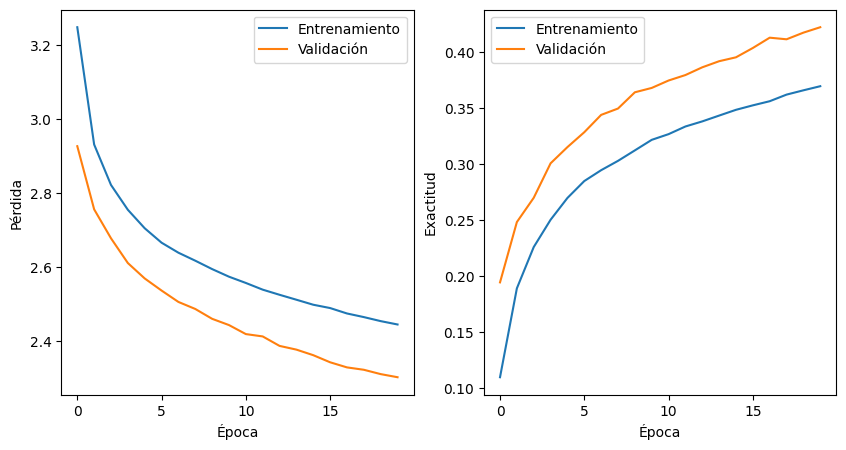

In [68]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

In [69]:
total_pru = 0
acum_exact = 0.
for X_pru, y_pru, _, _ in dl_pru:
    X_pru = pad(X_pru)
    X_pru = X_pru.to(DC)
    y_pru = y_pru.to(DC)
    y_hat_pru = mejor_vit(X_pru)
    total_pru += 1
    acum_exact += exactitud(y_hat_pru, y_pru)
exact_prom = acum_exact/total_pru
print("Exactitud en conjunto de prueba:\n", exact_prom)

Exactitud en conjunto de prueba:
 tensor(0.3564, device='cuda:0')
